In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import matplotlib as mpl
import numpy as np
from h5py import File

spots_directory = Path(r"D:\Tracking\DrosophilaNucleusTracking\data\spots")
save_path = Path(r"D:\OneDrive - Princeton University\Lab Meetings\2025_09_15 Shvartsman lab figures\Subfigures")

rc = {
    # "figure.facecolor": "#FFFFFF00",
    # "axes.facecolor": "#FFFFFF00",
    "legend.framealpha": 0.2,
    "lines.color": "k",
    "svg.fonttype": "none",
}

sns.set_context("paper")
sns.set_theme(style="ticks", font="Arial", rc=rc)

# print(mpl.font_manager.get_font_names())
nc_pal = {11: "coral", 12: "mediumseagreen", 13: "cadetblue", 14: "#895794"}
trk_pal = ["steelblue", "gold"]
four_color_pal = ["#44af69", "#f8333c", "#fcab10", "#2b9eb3"]
spots_dfs = []
metadatas = []

for i, spots_path in tqdm(enumerate(spots_directory.glob("*_spots.h5")), desc="reading spots dfs"):
    print(spots_path)
    spots_df = pd.read_hdf(spots_path, key="df")

    spots_df["source"] = i

    metadata = {}

    with File(spots_path, "r") as f:
        m = f["metadata"]
        metadata.update(m.attrs)

    metadatas.append(metadata)

    # print(metadata)

    dtw_path = spots_directory / "dtw" / f"{spots_path.stem}_dtw.h5"
    if dtw_path.exists():
        dtw_update = pd.read_hdf(dtw_path, key="df")
        spots_df = pd.merge(
            spots_df, dtw_update, left_index=True, right_index=True, how="left"
        )
        spots_df["cycle_pseudotime"] = spots_df["pseudotime"] + spots_df["cycle"] - 11
    else:
        spots_df["distance"] = np.nan  # rename this later
        spots_df["pseudotime"] = np.nan

    spots_dfs.append(spots_df)

reading spots dfs: 0it [00:00, ?it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20241104_spots.h5


reading spots dfs: 1it [00:00,  1.43it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250131_spots.h5


reading spots dfs: 2it [00:01,  1.42it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250206_spots.h5


reading spots dfs: 3it [00:02,  1.51it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250414_spots.h5


reading spots dfs: 4it [00:02,  1.43it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250625_spots.h5


reading spots dfs: 5it [00:03,  1.16it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250627_spots.h5


reading spots dfs: 6it [00:04,  1.23it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250702_spots.h5


reading spots dfs: 7it [00:05,  1.19it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250704_spots.h5


reading spots dfs: 8it [00:06,  1.20it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_20250705_spots.h5


reading spots dfs: 9it [00:07,  1.06it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_trk_20250318_spots.h5


reading spots dfs: 10it [00:08,  1.10it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_trk_20250319a_spots.h5


reading spots dfs: 11it [00:09,  1.19it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_trk_20250319b_spots.h5


reading spots dfs: 12it [00:09,  1.27it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_trk_20250321_spots.h5


reading spots dfs: 13it [00:10,  1.20it/s]

D:\Tracking\DrosophilaNucleusTracking\data\spots\lightsheet_trk_20250325_spots.h5


reading spots dfs: 14it [00:11,  1.24it/s]


In [55]:
from scipy.spatial import Voronoi
import napari
#
spots_df = spots_dfs[3]
#
nc_10_frame = 62
#
# vor = Voronoi(spots_df[spots_df["frame"] == nc_10_frame][["x", "y", "z"]])
#
# viewer = napari.Viewer()
#
# shapes = []
#
# for ridge in vor.ridge_points:
#     if -1 not in ridge:
#         points = vor.points[ridge]
#
#         # if np.max(np.abs(points)) > 1e4:
#         #     continue
#
#         shapes.append(points)
#
# print([s.shape for s in shapes])
#
# viewer.add_shapes(shapes, shape_type="path")
#
# napari.run()


In [56]:
import pymeshlab
from blender_tissue_cartography import interface_pymeshlab as intmsl
from blender_tissue_cartography import remesh_pymeshlab as tcremesh_pymeshlab

import igl

v_points = spots_df[spots_df["frame"] == spots_df["frame"].max()][["x", "y", "z"]]

from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import mesh as tcmesh
from blender_tissue_cartography import remesh as tcremesh
from blender_tissue_cartography import interpolation as tcinterp
from blender_tissue_cartography import registration as tcreg
from blender_tissue_cartography import morphsnakes
from sklearn.cluster import DBSCAN
from scipy.stats import mode

point_cloud = tcmesh.ObjMesh(vertices=v_points, faces=[])
point_cloud_pymeshlab = intmsl.convert_to_pymeshlab(point_cloud)
ms = pymeshlab.MeshSet()
ms.add_mesh(point_cloud_pymeshlab)

ms.compute_normal_for_point_clouds(k=20, smoothiter=2)
ms.generate_surface_reconstruction_screened_poisson(depth=8, fulldepth=5, )

ms.meshing_isotropic_explicit_remeshing(iterations=10, targetlen=pymeshlab.PercentageValue(0.6))

mesh_reconstructed = intmsl.convert_from_pymeshlab(ms.current_mesh())

print(mesh_reconstructed.faces.shape)

(47066, 3)


In [7]:
# from napari.layers import Surface
# from napari.layers.surface.surface import (
#     calculate_barycentric_coordinates,
#     find_nearest_triangle_intersection,
#     nd_line_segment_to_displayed_data_ray,
# )
#
# def vectormax(a):
#     """
#     Takes a vector a and returns a vector with a 1 in the position of the maximum value of a and 0s elsewhere.
#     """
#     b = np.zeros_like(a)
#     b[np.argmax(a)] = 1
#     return b
#
# class SurfaceNoInterp(Surface):
#
#     def _get_value_3d(
#         self,
#         start_point: np.ndarray | None,
#         end_point: np.ndarray | None,
#         dims_displayed: list[int],
#     ) -> tuple[None | float | int, int | None]:
#         """Get the layer data value along a ray
#
#         Parameters
#         ----------
#         start_point : np.ndarray
#             The start position of the ray used to interrogate the data.
#         end_point : np.ndarray
#             The end position of the ray used to interrogate the data.
#         dims_displayed : List[int]
#             The indices of the dimensions currently displayed in the Viewer.
#
#         Returns
#         -------
#         value
#             The data value along the supplied ray.
#         vertex : None
#             Index of vertex if any that is at the coordinates.
#         """
#         if len(dims_displayed) != 3:
#             # only applies to 3D
#             return None, None
#         if (start_point is None) or (end_point is None):
#             # return None if the ray doesn't intersect the data bounding box
#             return None, None
#
#         start_position, ray_direction = nd_line_segment_to_displayed_data_ray(
#             start_point=start_point,
#             end_point=end_point,
#             dims_displayed=dims_displayed,
#         )
#
#         # get the mesh triangles
#         mesh_triangles = self._data_view[self._view_faces]
#
#         # get the triangles intersection
#         intersection_index, intersection = find_nearest_triangle_intersection(
#             ray_position=start_position,
#             ray_direction=ray_direction,
#             triangles=mesh_triangles,
#         )
#
#         if intersection_index is None or intersection is None:
#             return None, None
#
#         # add the full nD coords to intersection
#         intersection_point = start_point.copy()
#         intersection_point[dims_displayed] = intersection
#
#         # calculate the value from the intersection
#         triangle_vertex_indices = self._view_faces[intersection_index]
#         triangle_vertices = self._data_view[triangle_vertex_indices]
#         barycentric_coordinates = calculate_barycentric_coordinates(
#             intersection, triangle_vertices
#         )
#         vertex_values = self._view_vertex_values[triangle_vertex_indices]
#         intersection_value = (vectormax(barycentric_coordinates) * vertex_values).sum()
#
#         return intersection_value, intersection_index

In [57]:
from scipy.spatial.distance import cdist
import colorcet as cc
from napari.utils.theme import get_theme, register_theme

verts = mesh_reconstructed.vertices
faces = mesh_reconstructed.faces

In [58]:
points2 = spots_df[spots_df["frame"] == spots_df["frame"].max()][["x", "y", "z"]]
points = spots_df[spots_df["frame"] == nc_10_frame][["x", "y", "z"]]

custom_theme = get_theme("dark")
custom_theme.canvas = "#ffffff"
custom_theme.id = "glasbey"
register_theme("glasbey", custom_theme, "custom")

glasbey = cc.glasbey

verts = mesh_reconstructed.vertices
faces = mesh_reconstructed.faces

dists = cdist(verts, points)
min_dists = np.argmin(dists, axis=1)

vals = spots_df[spots_df["frame"] == nc_10_frame]["track_id"].values[min_dists]

colors = [glasbey[a % 255] for a in vals]

# viewer = napari.Viewer()
# viewer.theme = "glasbey"
#
# print(cc.glasbey)
# g_231 = [(cc.glasbey[g] if (g == 231) else "#999999") for g in vals]
# print(g_231)
#
# surface = (verts, faces, vals)
# #
# # surface_no_interp = SurfaceNoInterp(data=surface, shading="flat", name="surface_no_interp")
# #
# # viewer.add_layer(surface_no_interp)
# viewer.add_surface(surface, shading="flat", name="surface_interp", colormap=g_231)
#
# # viewer.add_surface(surface)
#
# # viewer.add_points(mesh_reconstructed.vertices, face_color=colors, size=3.0, border_width=0, antialiasing=0.0)
#
# napari.run()

In [73]:
viewer = napari.Viewer()
viewer.theme = "glasbey"

dists = cdist(verts, points)
min_dists = np.argmin(dists, axis=1)

vals = spots_df[spots_df["frame"] == nc_10_frame]["track_id"].values[min_dists]

colors = [glasbey[a % 255] for a in vals]
point_colors = [glasbey[a % 255] for a in spots_df[spots_df["frame"] == nc_10_frame]["track_id"].values]

viewer.add_points(mesh_reconstructed.vertices, face_color=colors, size=3.0, border_width=0, antialiasing=0.0, properties=list(vals))
viewer.add_points(points, face_color=point_colors, size=5.0, border_width=0, antialiasing=0.0)

dists = cdist(verts, points2)
min_dists = np.argmin(dists, axis=1)

vals = spots_df[spots_df["frame"] == spots_df["frame"].max()]["track_id"].values[min_dists]

colors = [glasbey[a % 255] for a in vals]


viewer.add_points(mesh_reconstructed.vertices, face_color=colors, size=3.0, border_width=0, antialiasing=0.0, properties=list(vals))

napari.run()

In [24]:
points2 = spots_df[spots_df["frame"] == spots_df["frame"].max()][["x", "y", "z"]]

dists = cdist(verts, points2)
min_dists = np.argmin(dists, axis=1)

vals = spots_df[spots_df["frame"] == spots_df["frame"].max()]["track_id"].values[min_dists]

colors = [glasbey[a % 255] if a == 231 else "#999999" for a in vals]

viewer = napari.Viewer()
viewer.theme = "glasbey"

viewer.add_points(mesh_reconstructed.vertices, face_color=colors, size=3.0, border_width=0, antialiasing=0.0, properties=list(vals))


dists = cdist(verts, points)
min_dists = np.argmin(dists, axis=1)

vals = spots_df[spots_df["frame"] == nc_10_frame]["track_id"].values[min_dists]

colors = [glasbey[a % 255] if a == 231 else "#ffffff00" for a in vals]

viewer.add_points(mesh_reconstructed.vertices, face_color=colors, size=3.0, border_width=0, antialiasing=0.0)

napari.run()

In [69]:
points2 = spots_df[spots_df["frame"] == spots_df["frame"].max()][["x", "y", "z"]]

dists = cdist(verts, points2)
min_dists = np.argmin(dists, axis=1)

vals_final = spots_df[spots_df["frame"] == spots_df["frame"].max()]["track_id"].values[min_dists]

dists = cdist(verts, points)
min_dists = np.argmin(dists, axis=1)

vals_initial = spots_df[spots_df["frame"] == nc_10_frame]["track_id"].values[min_dists]

weights = []

for node in tqdm(graph.nodes):
    edges = graph.edges(node, data=True)
    # print(edges)

    weights.append(np.mean([e[2]["weight"] for e in graph.edges(node, data=True)]))

weights = np.array(weights) / 2
weights = np.pi * (weights**2)

final_frame_areas = {}
initial_frame_areas = {}

for v_final, v_initial, w in zip(vals_final, vals_initial, weights):
    if v_final not in final_frame_areas:
        final_frame_areas[v_final] = 0
    final_frame_areas[v_final] += w

    if v_initial not in initial_frame_areas:
        initial_frame_areas[v_initial] = 0
    initial_frame_areas[v_initial] += w

final_frame_areas = pd.Series(final_frame_areas)
initial_frame_areas = pd.Series(initial_frame_areas)


100%|██████████| 23535/23535 [00:00<00:00, 55625.52it/s]


In [62]:
import networkx as nx
from tqdm import tqdm

graph = nx.Graph()

for face in tqdm(faces):

    for i in range(3):
        a = face[i]
        b = face[(i+1)%3]

        graph.add_edge(a, b, weight=np.linalg.norm(verts[a] - verts[b]))

print(len(graph.nodes), len(graph.edges))



100%|██████████| 47066/47066 [00:01<00:00, 25868.78it/s]

23535 70599


In [43]:
def get_source_target_dists(graph, sources, targets):

    distances = []

    for s, t in tqdm(zip(sources, targets)):
        assert s in graph.nodes, f"Source {s} not in graph"
        assert t in graph.nodes, f"Target {t} not in graph"

        distances.append(nx.shortest_path_length(graph, source=s, target=t, weight="weight"))

    return distances

get_source_target_dists(graph, [0, 10, 20, 0], [100, 200, 300, 5000])

4it [00:00, 46.50it/s]


[np.float64(122.36848560726348),
 np.float64(32.684777497995256),
 np.float64(64.8843301697861),
 np.float64(216.936826670664)]

In [64]:
df_final = spots_df[spots_df["frame"] == spots_df["frame"].max()]
n_tracklets = df_final.track_id.value_counts()
best_tracklets = n_tracklets[n_tracklets > 15].index

In [65]:


spots_df_tracklets = spots_df[spots_df["track_id"].isin(best_tracklets)]
spots_df_tracklets = spots_df_tracklets[spots_df_tracklets["frame"] >= nc_10_frame]

final_points_df = spots_df_tracklets[spots_df_tracklets["frame"] == spots_df_tracklets["frame"].max()].groupby("track_id")[["x", "y", "z"]].mean()

final_points = final_points_df.values
final_id = final_points_df.index.values

nearest_vert_final = np.argmin(cdist(verts, final_points), axis=0)

initial_points_df = spots_df_tracklets.groupby("track_id")[["x", "y", "z"]].first()

initial_points = initial_points_df.values
initial_id = initial_points_df.index.values

nearest_vert_initial = np.argmin(cdist(verts, initial_points), axis=0)

anterior_vert = np.argmin(verts[:, 1])
posterior_vert = np.argmax(verts[:, 1])

n = len(nearest_vert_initial)

anterior_dist_initial = get_source_target_dists(graph, [anterior_vert]*n, nearest_vert_initial)
anterior_dist_final = get_source_target_dists(graph, [anterior_vert]*n, nearest_vert_final)
displacements = get_source_target_dists(graph, nearest_vert_initial, nearest_vert_final)

posterior_dist_initial = get_source_target_dists(graph, [posterior_vert]*n, nearest_vert_initial)
posterior_dist_final = get_source_target_dists(graph, [posterior_vert]*n, nearest_vert_final)

222it [00:15, 14.10it/s]
222it [00:16, 13.45it/s]
222it [00:00, 1530.69it/s]
222it [00:16, 13.75it/s]
222it [00:15, 14.59it/s]


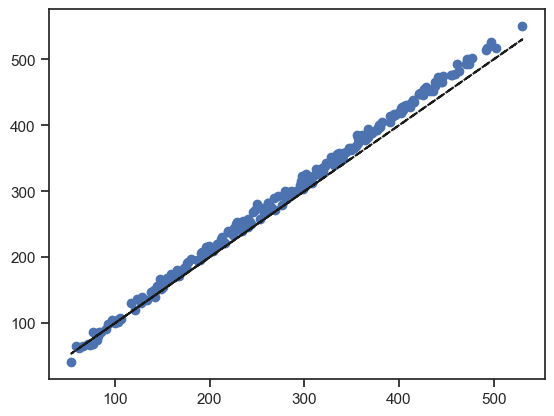

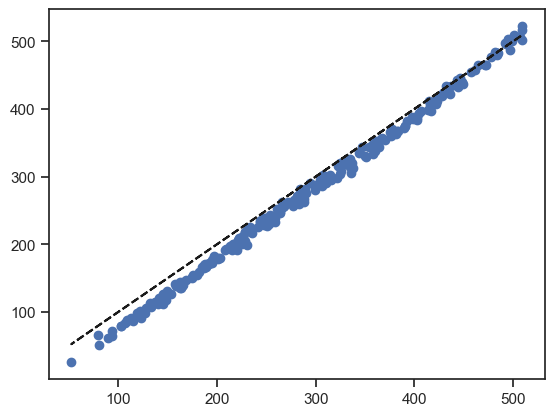

In [66]:
plt.scatter(anterior_dist_initial, anterior_dist_final, c="C0", label="anterior")
plt.plot(anterior_dist_initial, anterior_dist_initial, c="k", ls="--")
plt.show()

plt.scatter(posterior_dist_initial, posterior_dist_final, c="C0", label="anterior")
plt.plot(posterior_dist_initial, posterior_dist_initial, c="k", ls="--")
plt.show()


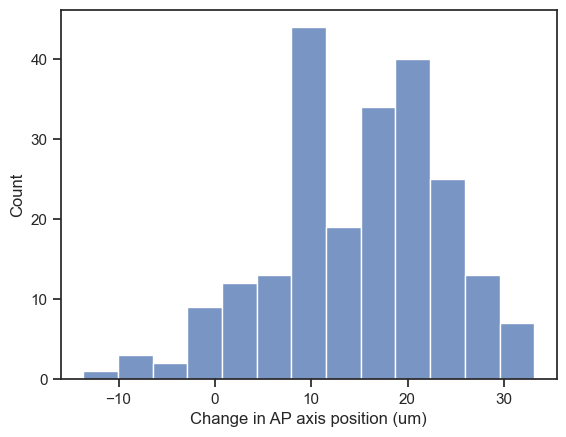

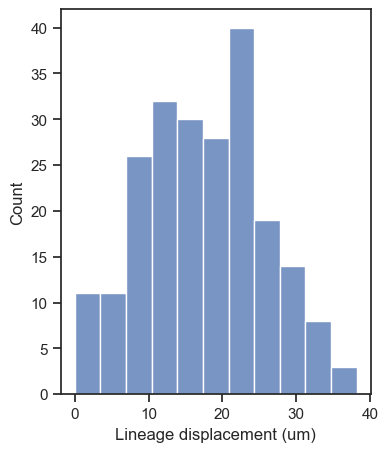

In [84]:
adf = np.array(anterior_dist_final)
adi = np.array(anterior_dist_initial)
pdf = np.array(posterior_dist_final)
pdi = np.array(posterior_dist_initial)

sns.histplot(-(pdf - pdi))
plt.xlabel("Change in AP axis position (um)")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(4, 5))
sns.histplot(displacements)
plt.xlabel("Lineage displacement (um)")
plt.show()

100%|██████████| 24523/24523 [00:00<00:00, 48839.36it/s]


In [12]:
weights

[np.float64(3.5503259193948447),
 np.float64(3.6120881291454205),
 np.float64(3.313522678314826),
 np.float64(3.190739095578607),
 np.float64(3.2850676973163395),
 np.float64(2.7756176592650297),
 np.float64(3.7291740865700436),
 np.float64(3.4206865931989126),
 np.float64(3.6428399157916935),
 np.float64(3.483290128513539),
 np.float64(3.397441261963369),
 np.float64(2.8572596453652226),
 np.float64(3.201741667917514),
 np.float64(3.2216942831281155),
 np.float64(3.1158247878729113),
 np.float64(3.2312926866840184),
 np.float64(3.1927427504929113),
 np.float64(3.0629577380185755),
 np.float64(3.407726711823186),
 np.float64(2.9579381769209165),
 np.float64(3.42242236522165),
 np.float64(3.2399679960277354),
 np.float64(3.2831581927586924),
 np.float64(3.26475983377099),
 np.float64(3.5343692880351436),
 np.float64(2.9864358347105333),
 np.float64(3.3367398532397683),
 np.float64(3.7207537048994217),
 np.float64(3.5888418332729635),
 np.float64(3.75913127575958),
 np.float64(3.13052335

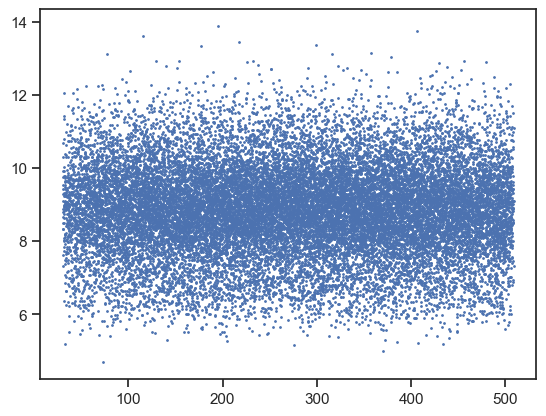

In [70]:
plt.scatter(verts[:, 1], weights, s=1)
plt.show()

17.58471995020481 14.934061594636686 8.028514075764525


C:\Users\Harrison\.conda\envs\dnt\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


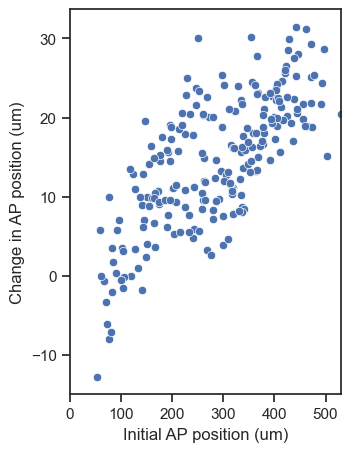

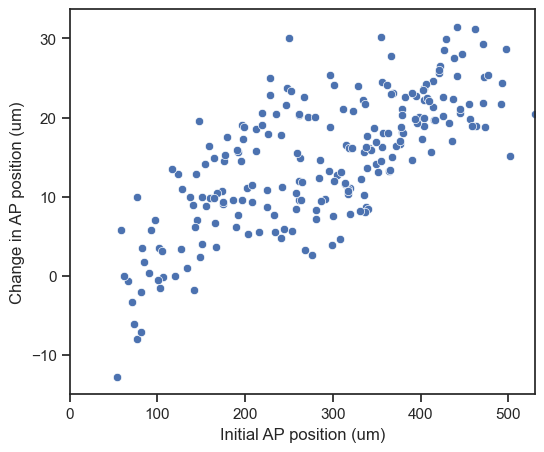

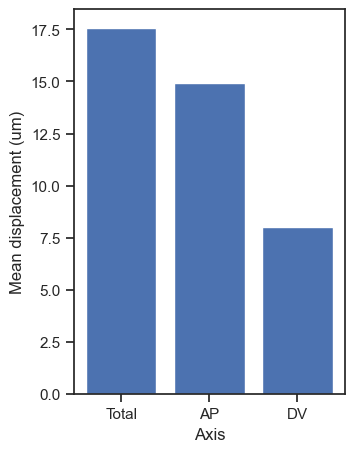

In [91]:
best_tracklets_inclusive = [b for b in best_tracklets if b in final_frame_areas.index and b in initial_frame_areas.index]

df_areas = {
    "tracklet": best_tracklets_inclusive,
    "final_area": final_frame_areas[best_tracklets_inclusive].values,
    "initial_area": initial_frame_areas[best_tracklets_inclusive].values,
    "initial_anterior": [a for a, b in zip(adi, best_tracklets) if b in best_tracklets_inclusive],
    "final_anterior": [a for a, b in zip(adf, best_tracklets) if b in best_tracklets_inclusive],
    "initial_posterior": [a for a, b in zip(pdi, best_tracklets) if b in best_tracklets_inclusive],
    "final_posterior": [a for a, b in zip(pdf, best_tracklets) if b in best_tracklets_inclusive],
    "displacement": [a for a, b in zip(displacements, best_tracklets) if b in best_tracklets_inclusive],
    "anterior_change": [fa - ia for ia, fa, b in zip(adi, adf, best_tracklets) if b in best_tracklets_inclusive],
}

df_areas = pd.DataFrame(df_areas)
df_areas["ratio"] = df_areas["final_area"] / df_areas["initial_area"]
df_areas["ap_displacement"] = df_areas["anterior_change"].abs()
df_areas["dv_change"] = np.sqrt(df_areas["displacement"]**2 - df_areas["ap_displacement"]**2)

print(df_areas["displacement"].mean(), df_areas["ap_displacement"].mean(), df_areas["dv_change"].mean())

fig, ax = plt.subplots(1, 1, figsize=(3.5, 5))
plt.xticks([0, 100, 200, 300, 400, 500, 600])
plt.xlim([0, df_areas["initial_anterior"].max()])
plt.xlabel("Initial AP position (um)")
plt.ylabel("Change in AP position (um)")
sns.scatterplot(df_areas, x="initial_anterior", y="anterior_change")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.xticks([0, 100, 200, 300, 400, 500, 600])
plt.xlim([0, df_areas["initial_anterior"].max()])
plt.xlabel("Initial AP position (um)")
plt.ylabel("Change in AP position (um)")
sns.scatterplot(df_areas, x="initial_anterior", y="anterior_change")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(3.5, 5))
plt.bar(["Total", "AP", "DV"], [df_areas["displacement"].mean(), df_areas["ap_displacement"].mean(), df_areas["dv_change"].mean()])
plt.xlabel("Axis")
plt.ylabel("Mean displacement (um)")
plt.show()

In [71]:
# # try setting faces for napari using shapes layer
#
# dists = cdist(verts, points)
#
# print(faces.shape)
# face_vertices = verts[faces]
# print(face_vertices.shape)
#
# facedists = dists[faces[:, 0]] + dists[faces[:, 1]] + dists[faces[:, 2]]
# print(facedists.shape)
#
# min_dists = np.argmin(facedists, axis=1)
# vals = spots_df[spots_df["frame"] == nc_10_frame]["track_id"].values[min_dists]
#
# colors = [glasbey[a % 255] for a in vals]
#
# viewer = napari.Viewer()
#
# viewer.theme = "glasbey"
# viewer.add_shapes(face_vertices, shape_type="polygon", edge_color="black", face_color=colors, name="faces")
#
# napari.run()

(17822, 3)
(17822, 3, 3)
(17822, 347)
